In [2]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax.ops import index_update
from jax import random
import matplotlib.pyplot as plt

import morphine
from morphine.matrixDFT import minimal_dft
import poppy

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as u

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


<ipython-input-2-25255b8c1035>:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  phasemap.set_bad(color='k')


In [3]:
D = 2.
wavelen = 1e-6

NPIX = 128
FOV = 8.

def morphine_min(wavel):
    empty = morphine.OpticalSystem(npix=NPIX)
    empty.add_pupil( morphine.CircularAperture(radius=1.),npix=NPIX)
    empty.add_detector( pixelscale=0.025, fov_arcsec=FOV )
    psf, instrument = empty.propagate_mono(wavel,retain_intermediates=False)
    return psf.intensity

jit_morphine = jit(morphine_min)

def poppy_basic(wavel):
    empty = poppy.OpticalSystem(npix=NPIX)
    empty.add_pupil( poppy.CircularAperture(radius=1.),npix=NPIX)
    empty.add_detector( pixelscale=0.025, fov_arcsec=FOV )
    psf, instrument = empty.propagate_mono(wavel)
    return psf[0].data

img_min = morphine_min(wavelen)
img_jit = jit_morphine(wavelen)
img_pop = poppy_basic(wavelen)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected.

The problem arose with the `bool` function. 

While tracing the function morphine_min at <ipython-input-3-20dfec2664cf>:7, this value became a tracer due to JAX operations on these lines:

  operation c:int32[] = abs b:int32[]
    from line /Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/morphine_optics-0.9.2-py3.8.egg/morphine/optics.py:77 (__init__)

  operation e:bool[] = gt c:int32[] d:int32[]
    from line /Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/morphine_optics-0.9.2-py3.8.egg/morphine/optics.py:77 (__init__)

See https://jax.readthedocs.io/en/latest/faq.html#abstract-tracer-value-encountered-where-concrete-value-is-expected-error for more information.

Encountered tracer value: Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=0/1)>

In [ ]:
%%timeit
img_min = morphine_min(wavelen)

In [ ]:
%%timeit
img_jit = jit_morphine(wavelen)

In [4]:
%%timeit
img_pop = poppy_basic(wavelen)

20.6 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


NameError: name 'img_jit' is not defined

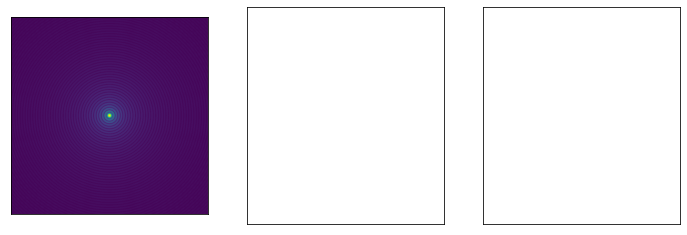

In [5]:
fig, axes = plt.subplots(1,3,figsize=(12.0,4.0))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].imshow(img_min**0.25)
axes[1].imshow(img_jit**0.25)
axes[2].imshow(img_pop**0.25)
